# Calculate $w_p$



In [49]:
# if __name__ == "__main__":
#     import argparse
#     parser = argparse.ArgumentParser()
#     parser.add_argument('input_file')
#     parser.add_argument('header_file')
#     parser.add_argument('output_file')
#     parser.add_argument('pimax')
#     parser.add_argument('rp_min')
#     parser.add_argument('rp_max')
#     parser.add_argument('nbins')
#     args = parser.parse_args()

In [50]:
import os.path
import numpy as np
import pandas as pd
import seaborn as sns

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline

In [52]:
sns.set_theme()
sns.set_style("dark")
sns.set_style("ticks")
sns.set(rc = {'figure.figsize':(15,8)})

In [53]:
project_path = "/global/cfs/cdirs/des/zhou/spt_lensing/"
infile_path = os.path.join(project_path,"data/results.npz")

In [54]:
infile = np.load(infile_path) 

# Calculate $w_p$ from $\xi$

$\begin{equation}
w_{p, A B}\left(r_{p}\right)=2 \int_{0}^{\Pi_{\max }} \xi_{A B}(r, \pi) d \pi
\end{equation}$

In [55]:
#Script passed on from A. Salcedo
import numpy as np
import scipy.integrate as integrate

def wp(rp,binmin,binmax,xi,pimax=None):
    """compute wp(r_p) from tabulated xi(r)."""
    
    lower_bound = rp 
    upper_bound = np.sqrt(rp**2 + pimax**2)
    binmask = np.logical_and(binmax > lower_bound, binmin < upper_bound)
    masked_xi = xi[binmask]
    r_i = binmin[binmask]
    r_iplus = binmax[binmask]
    s_plus = np.minimum(upper_bound, r_iplus)
    s_minus = np.maximum(lower_bound, r_i)
    # here we assume that xi is piecewise constant over the tabulated input bins
    elementwise_integral = 2.0*masked_xi * \
                           (np.sqrt(s_plus**2 - rp**2) - np.sqrt(s_minus**2 - rp**2))
    w_p = np.sum(elementwise_integral)

    return w_p

# Calcualte $\Delta \Sigma $ from $ w_p$ 

$\begin{equation}
\Delta \Sigma\left(r_{p}\right)=\Omega_{m} \rho_{\text {crit }}\left[\frac{2}{r_{p}^{2}} \int_{0}^{r_{p}} r^{\prime} w_{p, c m}\left(r^{\prime}\right) d r^{\prime}-w_{p, c m}\left(r_{p}\right)\right]
\end{equation}$

In [56]:
def DeltaSigma(binmin,binmax,xi,pimax=None,mean_rho=None,H0=None, rp_min=None, rp_max=None, nbins=None):
    # mean rho (in comoving Msun pc^-2, no little h)
    h = H0/100.

    # compute rp bins
    #nbins = 40
    #rp_min = 0.1
    #rp_max = 125.0
    rp_bins = np.logspace(np.log10(rp_min), np.log10(rp_max), nbins+1)
    rp_binmin = rp_bins[0:-1]
    rp_binmax = rp_bins[1:]
    rp_mid = (rp_binmin + rp_binmax)/2.0

    ds = np.zeros(rp_mid.shape[0])
    integrand = lambda r: r*wp(r,binmin,binmax,xi,pimax=pimax)
    for i in range(rp_mid.shape[0]):
        integral, abserr = integrate.quad(integrand, 0., rp_mid[i], epsabs=1.0e-2, epsrel=1.0e-2)
        ds[i] = (integral * (2.0/rp_mid[i]**2) - wp(rp_mid[i],binmin,binmax,xi,pimax=pimax)) * mean_rho

    # convert Mpc/h unit to pc (no h)
    #ds *= 1.0e6 / h
    ds *= 1.0e6 / h**2.0 #delta sigma comes out in Msun h / pc^2 units
    return rp_binmin, rp_binmax, ds

In [57]:
h = 0.6726

In [58]:
def DeltaSigma_from_files(header_file,filename,output_file,pimax,rp_min,rp_max,nbins):
    # read in cosmological parameters from header_file
    # import config
    # cf = config.AbacusConfigFile(header_file)
    # omega_m = cf.Omega_M # at z=0
    # H_0 = cf.H0
    
    H_0 = 67.26
    omega_m = 0.31415
    
    # compute mean_rho (comoving density units = Msun pc^-3)
    speed_of_light_km_s = 2.998e5 # km/s
    csq_over_G = 2.494e12 # 3c^2/(8*pi*G) Msun pc^-1
    
    mean_rho = omega_m * csq_over_G * (H_0/speed_of_light_km_s)**2 / 1.0e12 # Msun pc^-3
    
    print(filename)
    
    binmin,binmax,xi = np.loadtxt(filename,unpack=True)
    print(np.mean(xi))
    # print(binmin,binmax,xi)
    
    DS_binmin, DS_binmax, DS = DeltaSigma(binmin,binmax,xi,pimax=float(pimax),mean_rho=mean_rho,H0=H_0,rp_min=float(rp_min),rp_max=float(rp_max),nbins=int(nbins))
    np.savetxt(output_file, np.c_[DS_binmin, DS_binmax, np.zeros(DS.shape[0]), DS],
               delimiter='\t')
    return(np.array([DS_binmin,DS_binmax,DS]))

In [59]:
pimax = 100 #h^-1 Mpc
rp_min = 0.05
rp_max = 100
nbins = 20

In [60]:
modes = ["all","SPT","nonSPT"]
richness_bins=[5,10,14,20,30,45,60,np.inf]
headerfile=""
output_file = os.path.join(project_path,"data/DSigma.txt")

Delta_Sigma_array = [[None for _ in range(3)] for _ in range(4)]

for i in range(len(richness_bins))[-5:-1]:
    lambda_lower, lambda_upper = richness_bins[i],richness_bins[i+1]
    for j,mode in enumerate(modes):
        file_rel_path = f"data/result_DD_{lambda_lower}_{mode}_d30.txt"
        filename_ = os.path.join(project_path,file_rel_path)
        print(filename_)
        assert os.path.exists(filename_)
        print(i-3,j)
        DSigma = DeltaSigma_from_files(headerfile,filename_,output_file,pimax,rp_min,rp_max,nbins)
        print(np.mean(DSigma[2]))
        Delta_Sigma_array[i-3][j]= DSigma

/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_20_all_d30.txt
0 0
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_20_all_d30.txt
2088.2
24.67751313726224
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_20_SPT_d30.txt
0 1
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_20_SPT_d30.txt
2011.6333333333334
24.158867076821586
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_20_nonSPT_d30.txt
0 2
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_20_nonSPT_d30.txt
2230.9
23.427648934734325
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_30_all_d30.txt
1 0
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_30_all_d30.txt
2396.633333333333
28.360311494542014
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_30_SPT_d30.txt
1 1
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_30_SPT_d30.txt
2247.9333333333334
27.51162312646226
/global/cfs/cdirs/des/zhou/spt_lensing/data/result_DD_30_nonSPT_d30.txt
1 2
/global/cfs/cdirs/des/zhou/spt_lensing/data/r

In [61]:
for i in range(4):
    for j in range(3):
        print(np.mean(Delta_Sigma_array[i][j][2]))

24.67751313726224
24.158867076821586
23.427648934734325
28.360311494542014
27.51162312646226
26.159549016663625
32.12248141988583
30.45514625911884
28.374939190193437
32.84783637474014
45.84707751090254
29.67329994581803


In [62]:
for DSigma in np.array(Delta_Sigma_array):
    print(np.mean(DSigma[2]))

16.68098137121047
17.59161473185357
18.330078123030173
18.762865041571697


In [63]:
sns.set_style('ticks')

[-3.01839257e+01  5.65558405e+01  7.02500631e+01  9.16409228e+01
  7.71969898e+01  6.92977729e+01  5.06290795e+01  3.84841600e+01
  2.40295321e+01  1.57437237e+01  1.10035342e+01  6.77900281e+00
  4.69656534e+00  2.88404693e+00  2.44545076e+00  1.14287282e+00
  5.33912018e-01  2.49310333e-01  1.16762393e-01  5.46465318e-02]
[-2.72973718e+01  4.49547101e+01  6.57020468e+01  1.00361114e+02
  7.71996516e+01  6.72294804e+01  4.77490884e+01  3.69849475e+01
  2.37590588e+01  1.52843625e+01  1.13681150e+01  7.31682644e+00
  4.92514138e+00  2.99867076e+00  2.49848681e+00  1.16755307e+00
  5.45716738e-01  2.54518088e-01  1.19374304e-01  5.58511059e-02]
[-2.94641279e+01  7.26581382e+01  8.85466481e+01  9.39368165e+01
  7.32085719e+01  5.91505057e+01  3.91060681e+01  2.77496258e+01
  1.66510345e+01  1.03150667e+01  6.17921758e+00  3.96769408e+00
  2.69595827e+00  1.76928295e+00  1.12103256e+00  5.23410787e-01
  2.45029989e-01  1.14396559e-01  5.35809723e-02  2.50271436e-02]
[-3.16176013e+01  5.02

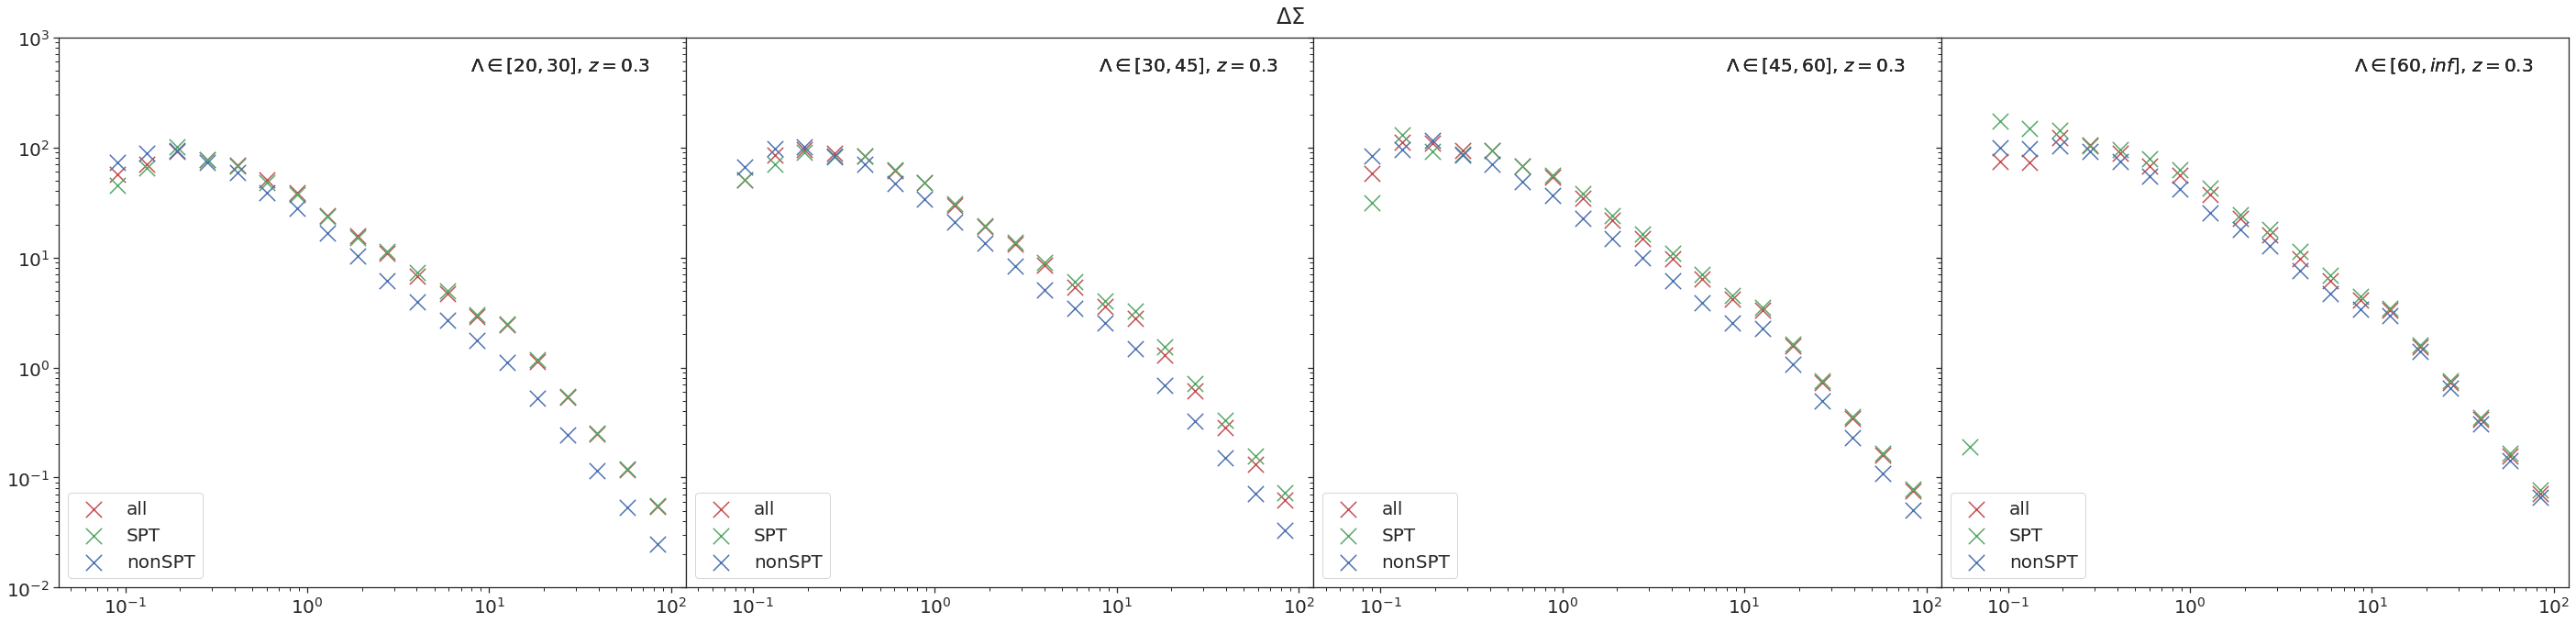

In [64]:
fig,axes = plt.subplots(ncols=4, figsize = [40,10],sharey=True)

modes = ["all","SPT","nonSPT"]
richness_bins=[5,10,14,20,30,45,60,np.inf]

plt.rcParams.update({'font.size':20})


for i in range(len(richness_bins))[-5:-1]:
    lambda_lower, lambda_upper = richness_bins[i],richness_bins[i+1]
    for j,mode in enumerate(modes):
        ax = axes[i-3]
        ax.text(0.80, 0.95, rf'$\Lambda \in [{lambda_lower},{lambda_upper}]$, $z=0.3$', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
        # print(i-3,j)
        DSigma = Delta_Sigma_array[i-3][j]
        print(DSigma[2])
        # plot1 = sns.lineplot(x=0.5*(DSigma[0]+DSigma[1]),y=DSigma[2],label=mode,ax=axes[i-3],legend=False)
        if mode == "all":
            color_= "r"
        elif mode == "SPT":
            color_ = "g"
        elif mode == "nonSPT":
            color_ = "b"
        ax.scatter(x=0.5*(DSigma[0]+DSigma[1]),y=DSigma[2],label=mode,marker="x",
                  c=color_, s=300)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim(0.01,1E3)
        # print(np.mean(DSigma[2]))
        # plot1.set(xscale="log",yscale="log",ylim=(0.01,1000))
        # plot2.set(xscale="log",yscale="log",ylim=(0.01,1E3))
        # plot2.legend(loc="lower left")
        ax.tick_params(axis='x', labelsize=20)
        ax.tick_params(axis='y', labelsize=20)
        ax.legend(loc="lower left",prop={'size':20})
    
# fig.get_axes()[0].annotate(r'$\Delta \Sigma$', (0.5, 0.95), 
#                             xycoords='figure fraction', ha='center', 
#                             fontsize=15
#                             )

fig.suptitle(r"$\Delta \Sigma$")
fig.tight_layout(pad=2)

plt.subplots_adjust(wspace=0)